## Multi-label classification and prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [ ]:
# ! {sys.executable} -m pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [4]:
!ls -trl kaggle.json

-rw-r--r--@ 1 bonacor  staff  64 Aug 10 10:41 kaggle.json


In [5]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [8]:
MYDIR = '/Users/bonacor/anaconda/TUTORIALs/fastai/My/nbs/dl1'   # change it as needed
path = Config.data_path()/MYDIR/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/Users/bonacor/anaconda/TUTORIALs/fastai/My/nbs/dl1/planet')

In [12]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [15]:
# ! echo {sys.prefix}

/Users/bonacor/anaconda/envs/venv_py37


In [14]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.14
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [17]:
# ! echo {path}

/Users/bonacor/anaconda/TUTORIALs/fastai/My/nbs/dl1/planet


In [16]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [19]:
# Pandas used as the standard way to handle tabular data in py

df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

---

### _NOTE: FIXME qui fare recap delle classi principali di pytorch_

**Also, plenty of more explanations here: https://github.com/fastai/fastai/blob/master/docs_src/data_block.ipynb**, with notes below (and remember to use <kbd>shift</kbd>+<kbd>TAB</kbd> to learn more about one specific method or function!).

E.g. from the docs above:

example MNIST

    data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
            .split_by_folder()              #How to split in train/valid? -> use the folders
            .label_from_folder()            #How to label? -> depending on the folder of the filenames
            .add_test_folder()              #Optionally add a test set (here default name is test)
            .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
            .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

example planet (smaller than this one)

    data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
            #Where to find the data? -> in planet 'train' folder
            .split_by_rand_pct()
            #How to split in train/valid? -> randomly with the default 20% in valid
            .label_from_df(label_delim=' ')
            #How to label? -> use the second column of the csv file and split the tags by ' '
            .transform(planet_tfms, size=128)
            #Data augmentation? -> use tfms with a size of 128
            .databunch())                          
            #Finally -> use the defaults for conversion to databunch

---

We will use get_transforms. With <kbd>shift</kbd>+<kbd>TAB</kbd> you can inspect what it does. By default, it will flip images not only horizontally but you also activate a vertical flipping (not OK for dogs vs cats, but OK for clouds!). The others are heuristics. Perspective warping is provided (and fast!) only by fastai: this is change of shape depending on from where you look at them (e.g. take a pic of a dog while you are standing or sitting); this is not really necessary for satellite images (always from top!) so put this to 0. This is data augmentation, we will say more.. In general, for astronomical data, aerial data etc these reasoning allow your models to generalize a bit better, so note it down!

In [20]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [21]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [22]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

_NOTE: if you studied the fastai.docs site for the data_block API, you have seen the previous 2 cells constructed as a uniqiue one. This can centrainly be done here as well, but you will see in a moment why we actually decided to split this in 2._

`show_batch` still works, and show us the different labels separated by `;`.

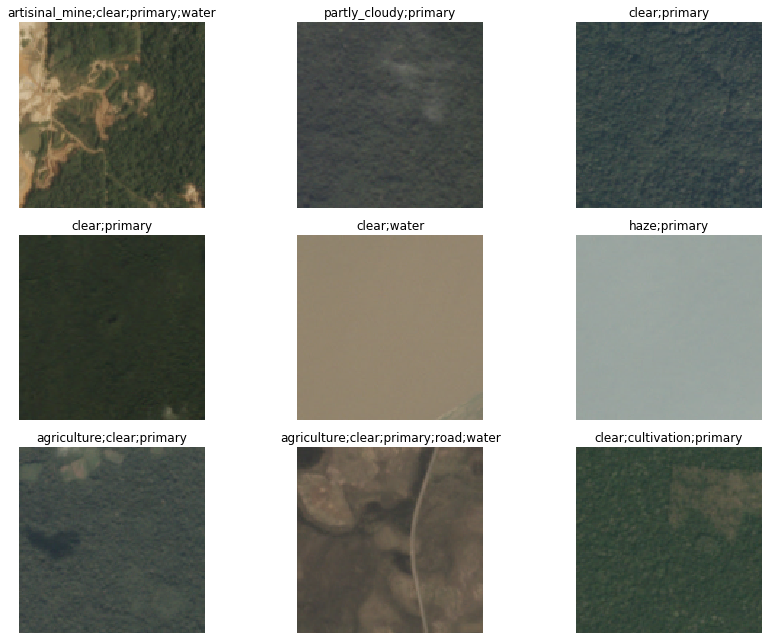

In [23]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [25]:
arch = models.resnet50

Remember we used accuracy before, and we discussed argmax? that works for bunary classif not multiclass!

In [33]:
accuracy??

Here we need something more sophisticated, and for variopus reasons.

In [34]:
# do not execute this.. only for teaching purposes..

fbeta() 

TypeError: fbeta() missing 2 required positional arguments: 'y_pred' and 'y_true'

the default is f2 - check the signature with shift-TAB

the threshold is very important - see AML BASIC course! 

A DataBunch has a special attribute called `c`: it tells how many outputs do we want our model to create. So for any classifier we might build on this dataset, we want one probability for each class. In thi case, 17 classes, so 17 probabilitioes. 

In [36]:
data.c

17

In other words:

In [37]:
data.c == len(data.classes)

True

where:

In [38]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

So, we are dealing not with 1 of them, and the connected probability (e.g. "is it a 7 or not" as in MNIST simplified), but with all 17 at a time. Note that it SEEMS like in a complete MNIST exercise if asking "which is the probability it is any of the 10 digits?", but the difference is that in that case only one answer is true! Here, many ansers could be true. E.g. "cloudy" and "forest". So, we compare each prob to some threshold and if the prob is > that threshold, then we conclude the pic has that specific feature. Here, we even put it very low.. 0.2 in this case. Note also that we need to use `accuracy_thresh`: the normal `accuracy` function does not work that way, it does not argmax, so we need to use `accuracy_thresh`, which will compute all the probs and will spit out those that are above the specified threshold.

shift+tab the cell below and you will see the default threshold would be 0.5. 

In [ ]:
# do not execute this.. only for teaching purposes..

# accuracy_thresh()

So in principle I would need to define an ad-hoc function, like:

In [42]:
# def acc_02(inp,target): return accuracy_thresh(inp,target,thresh=0.2)

Python3 allows me to use a `partial` function application. It takes a function, and a list of keywords and values, and creates a new function that is exactly the same apart from the newly specified parameters values. This is done frequently on fast.ai as you pass a slightly customized version of a function.

In [41]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

# NOTE: changing the metrics will not change AT ALL how the model trains.
# It is only used to be printed out during training, to show you how you are going.

# Here, I want accuracy, and Kaggle told me I am going to me judged by f1_score, so I add it.

From now onwards, all normal stuff we have seen before.

We use the LR Finder to pick a good learning rate.

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


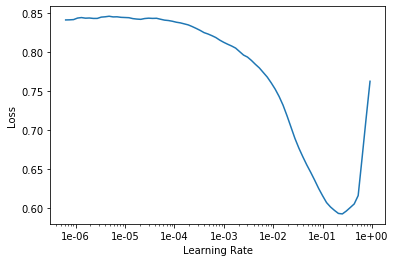

In [44]:
learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.125128,0.110038,0.944010,0.904893
2,0.112533,0.101303,0.955964,0.910774
3,0.100574,0.093255,0.955187,0.918653
4,0.096056,0.087997,0.954983,0.924016
5,0.092320,0.086761,0.956400,0.925110


In [ ]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [ ]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


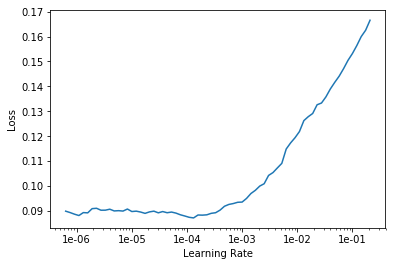

In [ ]:
learn.lr_find()
learn.recorder.plot()

Rule of thumb for the 2nd round: new plot, take the point where it is down before it goes up, take 10x-ish earlier and use that as left value (1e-5 here). Then, as right value, take the former (1st round) lr and do lr/5 or lr/10.

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.097016,0.094868,0.952004,0.916215
2,0.095774,0.088899,0.954540,0.922340
3,0.090646,0.085958,0.959249,0.924921
4,0.085097,0.083291,0.958849,0.928195
5,0.079197,0.082855,0.958602,0.928259


In [ ]:
learn.save('stage-2-rn50')

---

Can we do better?

I made a transform at 128. Because I want to experiment, and it is much quic ker to work with small images. But, there is a second reason: I built a model quickly, and I now have a model that is good at recognizing 128x128 satellite images: what if I want to create a model that is good with 256x256? **Idea: why don't I use transfer learning..** I start with a model that is already good at 128x128 images and fine tune that. 

Now you understand why we splitted before.. we restart from the `src` aboce, and do a different `data` step.

We are creating now a new DataBunch with 256x256 images. Same transforms, but `size=256`. This should be better anyway, as these will be higher resolution images. It will be slower, of course, but I will pay the price. Then I will replace `data` in my learner with the new dDataBunch, namely `learn.data = data`. And check the sie before proceeding.


In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

I will freeze again, i.e. I will re-train only the last layers:

In [ ]:
learn.freeze()

And I run again this part:

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


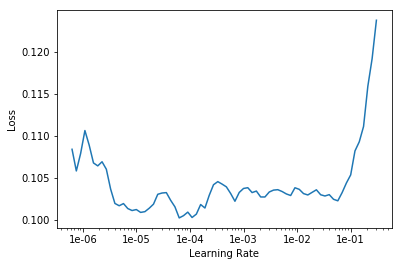

In [ ]:
learn.lr_find()
learn.recorder.plot()

As now I have a pretty good model for 128x128 images, I do not get the same sharp curve as before, but I can still see where it gets too high, and I am picking something well before it goes too high (FIXME perche- divide per 2 e non prende valore non so).

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087761,0.085013,0.958006,0.926066
2,0.087641,0.083732,0.958260,0.927459
3,0.084250,0.082856,0.958485,0.928200
4,0.082347,0.081470,0.960091,0.929166
5,0.078463,0.080984,0.959249,0.930089


You see that after a couple of passes you get a fbeta to where you were before, and then it increases further and passes 93%. **We are already safely into the best 10% in this Kaggle competition**. Of course we can do the same thing as before, and do more, unfreeze, etc.

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082938,0.083548,0.957846,0.927756
2,0.086312,0.084802,0.958718,0.925416
3,0.084824,0.082339,0.959975,0.930054
4,0.078784,0.081425,0.959983,0.929634
5,0.074530,0.080791,0.960426,0.931257


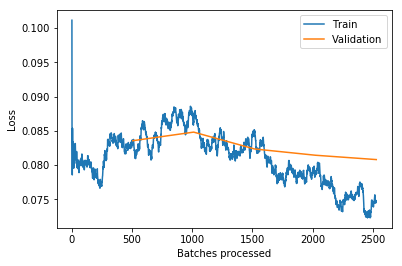

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)